In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('train.csv')
train_df.columns = train_df.columns.str.lower()
train_df.head(1)

,id,podcast_name,episode_title,episode_length_minutes,genre,host_popularity_percentage,publication_day,publication_time,guest_popularity_percentage,number_of_ads,episode_sentiment,listening_time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   podcast_name                 750000 non-null  object 
 2   episode_title                750000 non-null  object 
 3   episode_length_minutes       662907 non-null  float64
 4   genre                        750000 non-null  object 
 5   host_popularity_percentage   750000 non-null  float64
 6   publication_day              750000 non-null  object 
 7   publication_time             750000 non-null  object 
 8   guest_popularity_percentage  603970 non-null  float64
 9   number_of_ads                749999 non-null  float64
 10  episode_sentiment            750000 non-null  object 
 11  listening_time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df.drop("listening_time_minutes", axis=1), train_df["listening_time_minutes"], test_size=0.2, random_state=42)

In [5]:
days_dict = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6
}

sentiment_dict = {
    "Negative": -1, 
    "Neutral" : 0,
    "Positive": 1
}

def periodic_encode(data, max_val):
    return np.cos(2 * np.pi * np.array(data) / max_val), np.sin(2 * np.pi * np.array(data) / max_val) 

def basic_transform(df):
    df_copy = df.copy()
    df_copy.columns = df.columns.str.lower()
    # replace string episode title with int
    df_copy["episode_title"] = [int(x[8:]) for x in df["episode_title"]]
    # periodically encode day of the week
    df_copy["day_numerical_cos"] = periodic_encode([days_dict[x] for x in df["publication_day"]], 6)[0]
    df_copy["day_numerical_sin"] = periodic_encode([days_dict[x] for x in df["publication_day"]], 6)[1]
    df_copy = df_copy.drop(columns=["publication_day"])
    # convert episode sentiment to numerical
    df_copy["episode_sentiment"] = [sentiment_dict[x] for x in df["episode_sentiment"]]
    # podcast name get dummies
    df_copy = pd.get_dummies(df_copy, columns=["podcast_name"], dtype=int)
    df_copy["podcast_name"] = df["podcast_name"]
    # genre get dummies
    df_copy = pd.get_dummies(df_copy, columns=["genre"], dtype=int)
    # time get dummies
    df_copy = pd.get_dummies(df_copy, columns=["publication_time"], dtype=int)

    return df_copy

In [6]:
from sklearn.preprocessing import StandardScaler

# y train normalization 
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1))

In [7]:
X_train = basic_transform(X_train)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600000 entries, 453635 to 121958
Data columns (total 72 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id                                600000 non-null  int64  
 1   episode_title                     600000 non-null  int64  
 2   episode_length_minutes            530372 non-null  float64
 3   host_popularity_percentage        600000 non-null  float64
 4   guest_popularity_percentage       483107 non-null  float64
 5   number_of_ads                     599999 non-null  float64
 6   episode_sentiment                 600000 non-null  int64  
 7   day_numerical_cos                 600000 non-null  float64
 8   day_numerical_sin                 600000 non-null  float64
 9   podcast_name_Athlete's Arena      600000 non-null  int32  
 10  podcast_name_Brain Boost          600000 non-null  int32  
 11  podcast_name_Business Briefs      600000 non-null  i

In [8]:
X_train["number_of_ads"].fillna(X_train["number_of_ads"].median(), inplace=True)

C:\Users\semic\AppData\Local\Temp\ipykernel_3780\3268732972.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train["number_of_ads"].fillna(X_train["number_of_ads"].median(), inplace=True)


In [9]:
non_full_cols = []

for col in X_train.columns:
    if X_train[col].isna().sum() != 0:
        non_full_cols.append(col)

non_full_cols

['episode_length_minutes', 'guest_popularity_percentage']

In [23]:
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

def plot_importances(cols, importances, pct=80):
    cutoff = np.percentile(importances, pct)
    importances = np.array(importances)
    imp_dict = {col: imp for col, imp in zip(cols, importances)}
    imp_dict = {k: v for k, v in imp_dict.items() if v > cutoff}
    plt.bar(list(imp_dict.keys()), list(imp_dict.values()))
    plt.xticks(rotation=45, ha="right")
    plt.show()

def imputation_algo(data, target): 
    model = LGBMRegressor(force_row_wise=True)
    model.fit(np.array(data[~target.isna()]), np.array(target[~target.isna()]).reshape(-1, 1))
    res = model.predict(np.array(data[target.isna()]))
    plot_importances(data.columns, model.feature_importances_)
    return res

In [11]:
# keywords feature engineering
kwords = ["crim", "business", "tech", "finance", "health", "comedy", "fashion", "sports"]

def contains(kword, name):
    if kword in name.lower():
        return True
    else:
        return False

for i in kwords:
    name = f"title_contains_{i}"
    X_train[name] = [contains(i, x) for x in X_train["podcast_name"]]

d:\Users\semic\Anaconda3\envs\qfi\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 530372, number of used features: 76
[LightGBM] [Info] Start training from score 64.513383


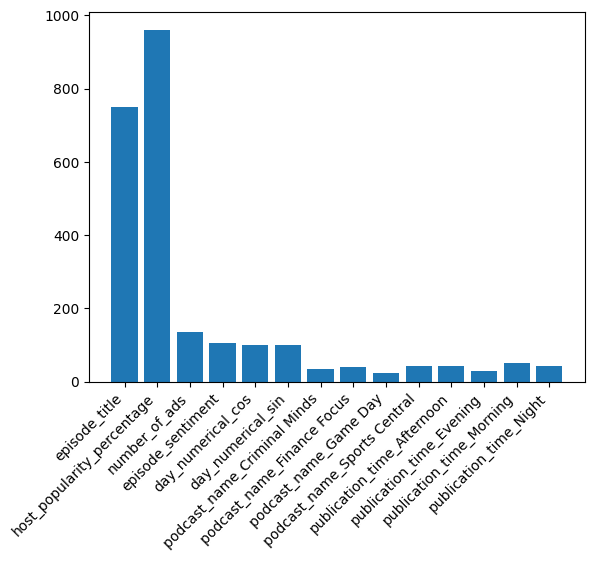

C:\Users\semic\AppData\Local\Temp\ipykernel_3780\3040123357.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed_X_train["episode_length_minutes"].fillna(
d:\Users\semic\Anaconda3\envs\qfi\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 483107, number of used features: 76
[LightGBM] [Info] Start training from score 52.262489


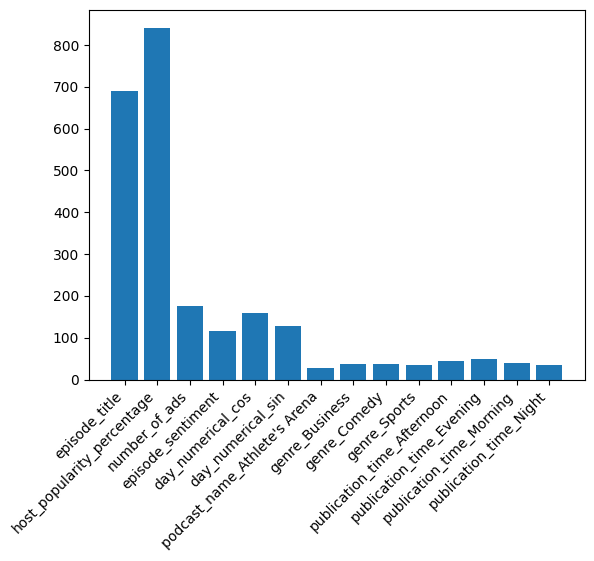

C:\Users\semic\AppData\Local\Temp\ipykernel_3780\3040123357.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed_X_train["guest_popularity_percentage"].fillna(


In [25]:
imputed_X_train = X_train.copy()
k = X_train.drop(["podcast_name", "id"], axis=1)
imputed_X_train["episode_length_minutes"].fillna(
    pd.Series(imputation_algo(k.drop(non_full_cols, axis=1), k["episode_length_minutes"])), inplace=True)
imputed_X_train["guest_popularity_percentage"].fillna(
    pd.Series(imputation_algo(k.drop(non_full_cols, axis=1), k["guest_popularity_percentage"])), inplace=True)

In [ ]:
imputed_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600000 entries, 453635 to 121958
Data columns (total 80 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id                                600000 non-null  int64  
 1   episode_title                     600000 non-null  int64  
 2   episode_length_minutes            536801 non-null  float64
 3   host_popularity_percentage        600000 non-null  float64
 4   guest_popularity_percentage       501465 non-null  float64
 5   number_of_ads                     600000 non-null  float64
 6   episode_sentiment                 600000 non-null  int64  
 7   day_numerical_cos                 600000 non-null  float64
 8   day_numerical_sin                 600000 non-null  float64
 9   podcast_name_Athlete's Arena      600000 non-null  int32  
 10  podcast_name_Brain Boost          600000 non-null  int32  
 11  podcast_name_Business Briefs      600000 non-null  i

In [133]:
from lightgbm import LGBMRegressor

# Initialize the model with RMSE as the evaluation metric
lgbm_model = LGBMRegressor(
    random_state=42,
    objective='regression',
    metric='rmse'  # Set metric to RMSE
)

# Convert y_train to the correct format if it's a Series
if isinstance(y_train, pd.Series):
    y_train = y_train.values

# Fit the model
lgbm_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train)],  # Optional: add validation set to monitor training
    eval_metric='rmse',             # Specify RMSE for evaluation during training                 # Show training progress
)

# For scoring, ensure X_test is properly transformed and y_test is in the right format
X_test_transformed = np.array(basic_transform(X_test))
y_test_transformed = y_scaler.transform(y_test.values.reshape(-1, 1) if isinstance(y_test, pd.Series) else y_test.reshape(-1, 1))

#
# Calculate RMSE explicitly
from sklearn.metrics import mean_squared_error
import numpy as np
y_pred = y_scaler.inverse_transform(lgbm_model.predict(X_test_transformed).reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_test_transformed.reshape(-1, 1)), y_pred))
print(f"RMSE: {rmse}")

d:\Users\semic\Anaconda3\envs\qfi\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1264
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 71
[LightGBM] [Info] Start training from score 0.000000
RMSE: 19.157224642554244


In [137]:
test_df = pd.read_csv('test.csv')
test_df.columns = test_df.columns.str.lower()
test_df = basic_transform(test_df)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 71 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id                                250000 non-null  int64  
 1   episode_title                     250000 non-null  int64  
 2   episode_length_minutes            221264 non-null  float64
 3   host_popularity_percentage        250000 non-null  float64
 4   guest_popularity_percentage       201168 non-null  float64
 5   number_of_ads                     250000 non-null  float64
 6   episode_sentiment                 250000 non-null  int64  
 7   day_numerical_cos                 250000 non-null  float64
 8   day_numerical_sin                 250000 non-null  float64
 9   podcast_name_Athlete's Arena      250000 non-null  int32  
 10  podcast_name_Brain Boost          250000 non-null  int32  
 11  podcast_name_Business Briefs      250000 non-null  i

In [138]:
X_test["episode_length_minutes"].fillna(X_test["episode_length_minutes"].median(), inplace=True)
X_test["guest_popularity_percentage"].fillna(X_test["guest_popularity_percentage"].median(), inplace=True)

C:\Users\semic\AppData\Local\Temp\ipykernel_8524\268996897.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test["episode_length_minutes"].fillna(X_test["episode_length_minutes"].median(), inplace=True)
C:\Users\semic\AppData\Local\Temp\ipykernel_8524\268996897.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [139]:
preds = y_scaler.inverse_transform(lgbm_model.predict(np.array(test_df)).reshape(-1, 1))
preds

array([[56.40261259],
       [18.08382091],
       [49.85246434],
       ...,
       [ 6.84351809],
       [73.68487859],
       [57.07473256]])

In [140]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

,id,Listening_Time_minutes
0,750000,45.437
1,750001,45.437
2,750002,45.437
3,750003,45.437
4,750004,45.437


In [141]:
sample_submission["Listening_Time_minutes"] = preds
sample_submission.to_csv("basic_submission.csv", index=False)